# Setup

In [ ]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 133.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 140.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 19.8 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"27a42d5900c0e3a2b31cb91648b983ef\"}" > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c gan-getting-started

100% 366M/367M [00:03<00:00, 102MB/s]
100% 367M/367M [00:03<00:00, 103MB/s]


In [ ]:
!unzip gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391d94b.jpg  
  inflating: photo_jpg/47df26

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import torch as torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import random
import os
import time
from skimage import io, color, filters
import zipfile
from PIL import Image
from tqdm import tqdm
import wandb
from torchsummary import summary
import io
from contextlib import redirect_stdout

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
BATCH_SIZE = 1
EPOCHS = 30

# Save and Load

In [3]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

In [4]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

# Data

In [6]:
dataset_path = "./gan-getting-started"

# List all image files in the dataset directory
photo_dir = os.path.join(dataset_path, "photo_jpg")
monet_dir = os.path.join(dataset_path, "monet_jpg")
photo_files = [os.path.join(photo_dir, file) for file in os.listdir(photo_dir) if file.endswith(('.jpg'))]
monet_files = [os.path.join(monet_dir, file) for file in os.listdir(monet_dir) if file.endswith(('.jpg'))]

# Create a pandas DataFrame with the image file paths
photo_df = pd.DataFrame({'image_path': photo_files})
monet_df = pd.DataFrame({'image_path': monet_files})

photo_df.head(), monet_df.head()

(                                       image_path
 0  ./gan-getting-started/photo_jpg/697a7cac68.jpg
 1  ./gan-getting-started/photo_jpg/4d1c4d142e.jpg
 2  ./gan-getting-started/photo_jpg/4e21145eb2.jpg
 3  ./gan-getting-started/photo_jpg/9999c76d32.jpg
 4  ./gan-getting-started/photo_jpg/a01c871721.jpg,
                                        image_path
 0  ./gan-getting-started/monet_jpg/a7d53885e8.jpg
 1  ./gan-getting-started/monet_jpg/fd63a333f1.jpg
 2  ./gan-getting-started/monet_jpg/7960adbd50.jpg
 3  ./gan-getting-started/monet_jpg/184d6c66cd.jpg
 4  ./gan-getting-started/monet_jpg/79224da51f.jpg)

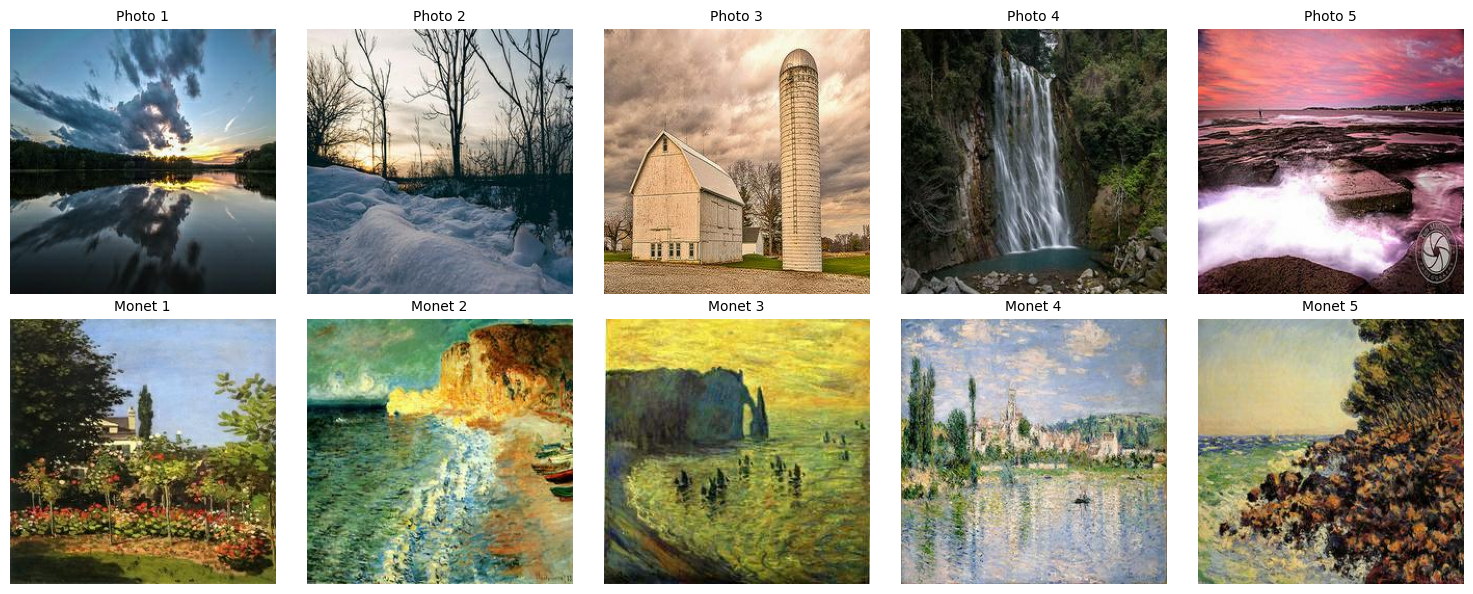

In [7]:
photo_examples = photo_df.sample(n=5)
monet_examples = monet_df.sample(n=5)

photo_examples_images = [Image.open(path) for path in photo_examples['image_path']]
monet_examples_images = [Image.open(path) for path in monet_examples['image_path']]

all_images = photo_examples_images + monet_examples_images

titles = [f'Photo {i+1}' for i in range(5)] + \
         [f'Monet {i+1}' for i in range(5)]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i, (img, title) in enumerate(zip(all_images, titles)):
    axes[i].imshow(img)
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
class ImageDataset(Dataset):
  def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
    super().__init__()
    self.monet_dir = monet_dir
    self.photo_dir = photo_dir
    self.monet_idx = dict()
    self.photo_idx = dict()
    if normalize:
      self.transform = transforms.Compose([
          transforms.Resize(size),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])
    else:
      self.transform = transforms.Compose([
          transforms.Resize(size),
          transforms.ToTensor()
          ])
    for i, fl in enumerate(os.listdir(self.monet_dir)):
      self.monet_idx[i] = fl
    for i, fl in enumerate(os.listdir(self.photo_dir)):
      self.photo_idx[i] = fl
    self.len = min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

  def __getitem__(self, idx):
    rand_idx = int(np.random.uniform(0, self.len))
    photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
    monet_path = os.path.join(self.monet_dir, self.monet_idx[rand_idx])
    photo_img = Image.open(photo_path)
    photo_img = self.transform(photo_img)
    monet_img = Image.open(monet_path)
    monet_img = self.transform(monet_img)
    return photo_img, monet_img

  def __len__(self):
    return self.len

In [9]:
img_ds = ImageDataset(monet_dir, photo_dir)
img_ds[0][0].shape, img_ds[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [10]:
img_dl = DataLoader(img_ds, batch_size=BATCH_SIZE, shuffle=True)

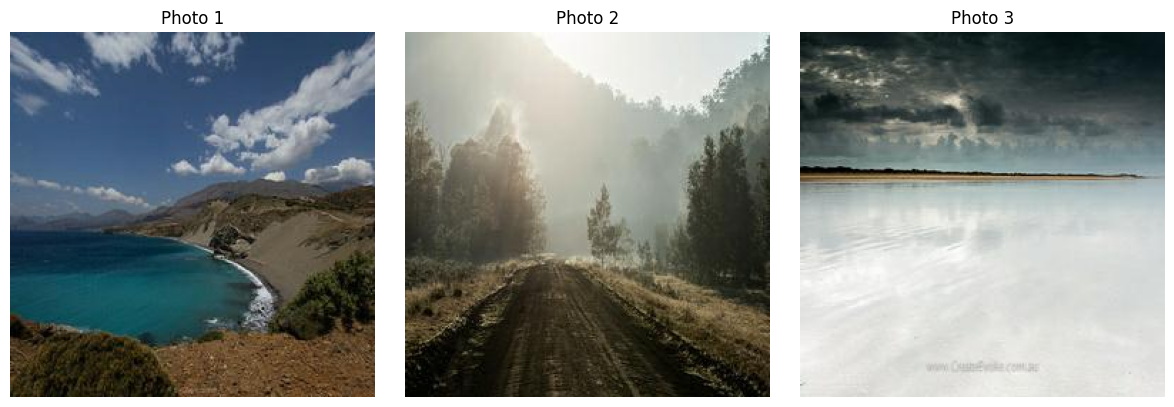

In [11]:
start = 0
val_photos = [img_ds[i][0] for i in range(start, start + 3)]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, img in enumerate(val_photos):
    # Unnormalize for display
    img_disp = img.cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axes[i].imshow(np.clip(img_disp, 0, 1))
    axes[i].axis('off')
    axes[i].set_title(f'Photo {i+1}')
plt.tight_layout()
plt.show()

# Models

## Blocks

why is GELU used in upsample?
why is stride 2 for upsample?

In [ ]:
class Downblock(nn.Module):
    def __init__(
        self,
        # dims
        in_ch, out_ch,
        # conv
        kernel_size=3, stride=1, padding=0, use_bias=True,
        # norm
        apply_norm=True, use_inst_norm=True,
        # activation
        activation='relu',
        # dropout
        dropout_ratio=0.0
        ):
        super().__init__()
        layers = []

        # 1. conv
        layers.append(nn.Conv2d(
            in_ch, out_ch,
            kernel_size, stride, padding,
            bias=use_bias
        ))

        # 2. norm
        if apply_norm:
            if use_inst_norm:
                layers.append(nn.InstanceNorm2d(out_ch))
            else:
                layers.append(nn.BatchNorm2d(out_ch))

        # 3. activation
        if activation != '':
            if activation == 'gelu':
                layers.append(nn.GELU())
            elif activation == 'leaky':
                layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
            else:
                layers.append(nn.ReLU(inplace=True))

        # 4. dropout
        if dropout_ratio > 0.0:
            layers.append(nn.Dropout(dropout_ratio))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class Resblock(nn.Module):
    def __init__(
        self,
        # dims
        in_features,
        # norm
        use_inst_norm=True,
        # activation
        use_gelu=True,
        # dropout
        dropout_ratio=0.0
        ):
        super().__init__()

        # 1. refl pad + down block (activation + dropout)
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Downblock(
            in_ch=in_features, out_ch=in_features,
            kernel_size=3, stride=1, padding=0, use_bias=True,
            apply_norm=True, use_inst_norm=use_inst_norm,
            activation='gelu' if use_gelu else 'relu',
            dropout_ratio=dropout_ratio
        ))

        # 2. refl pad + down block
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Downblock(
            in_ch=in_features, out_ch=in_features,
            kernel_size=3, stride=1, padding=0, use_bias=True,
            apply_norm=True, use_inst_norm=use_inst_norm,
            activation='',
            dropout_ratio=0.0
        ))

        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

In [ ]:
class Upblock(nn.Module):
    def __init__(
        self,
        # dims
        in_ch, out_ch,
        # conv transpose
        kernel_size=3, stride=2, padding=1, output_padding=1, use_bias=True,
        # norm
        apply_norm=True, use_inst_norm=True,
        # activation
        activation='relu',
        # dropout
        dropout_ratio=0.0
        ):
        super().__init__()
        layers = []

        # 1. conv transpose analog (fixes 'checkerboard artifacts')
        layers.append(nn.Upsample(scale_factor=stride, mode='nearest'))

        pad_size = kernel_size // 2
        layers.append(nn.ReflectionPad2d(pad_size))

        layers.append(nn.Conv2d(
            in_ch, out_ch,
            kernel_size=kernel_size,
            stride=1,  # Stride is always 1 here because we already upsampled
            padding=0, # Padding is handled by ReflectionPad2d above
            bias=use_bias
        ))

        # 2. norm
        if apply_norm:
            if use_inst_norm:
                layers.append(nn.InstanceNorm2d(out_ch))
            else:
                layers.append(nn.BatchNorm2d(out_ch))

        # 3. activation
        if activation != None:
            if activation == 'gelu':
                layers.append(nn.GELU())
            else:
                layers.append(nn.ReLU(inplace=True))

        # 4. Dropout
        if dropout_ratio > 0.0:
            layers.append(nn.Dropout(dropout_ratio))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, n_resblocks=6):
        super().__init__()

        model = list()
        model.append(nn.ReflectionPad2d(3))

        # Downsampling
        model.append(Downblock(
            in_ch=in_ch, out_ch=64,
            kernel_size=7, stride=1, padding=0, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=64, out_ch=128,
            kernel_size=3, stride=2, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=128, out_ch=256,
            kernel_size=3, stride=2, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=0.0
        ))

        # Residual blocks
        for _ in range(n_resblocks):
            model.append(Resblock(
                in_features=256,
                use_inst_norm=True,
                use_gelu=True,
                dropout_ratio=0.0
            ))

        # Upsampling
        model.append(Upblock(
            in_ch=256, out_ch=128,
            kernel_size=3, stride=2, padding=1, output_padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=0.0
        ))
        model.append(Upblock(
            in_ch=128, out_ch=64,
            kernel_size=3, stride=2, padding=1, output_padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=0.0
        ))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, stride=1, padding=0))

        # Scale output to [-1, 1]
        model.append(nn.Tanh())

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()

        model = list()

        # Downsampling
        model.append(Downblock(
            in_ch=in_ch, out_ch=64,
            kernel_size=4, stride=2, padding=1, use_bias=True,
            apply_norm=False, # no norm in first layer for better stability
            activation='leaky',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=64, out_ch=128,
            kernel_size=4, stride=2, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='leaky',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=128, out_ch=256,
            kernel_size=4, stride=2, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='leaky',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=256, out_ch=512,
            kernel_size=4, stride=1, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='leaky',
            dropout_ratio=0.0
        ))

        # Output layer
        model.append(nn.Conv2d(
            in_channels=512, out_channels=1,
            kernel_size=4, stride=1, padding=1
        ))

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## CycleGAN

### Helpers

In [ ]:
class lr_sched():
    def __init__(self, total_epochs=200):
        self.total_epochs = total_epochs
        self.decay_epochs = total_epochs/2

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [ ]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [ ]:
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

### Model

In [ ]:
class CycleGAN(nn.Module):
    def __init__(
        self,
        # generator
        in_ch=3, out_ch=3,
        epochs=20, lr=0.0002,
        cycle_weight=10.0, id_weight=5.0,
        ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.cycle_weight = cycle_weight
        self.id_weight = id_weight

        self.g_ptm = Generator(in_ch, out_ch).to(device)
        self.g_mtp = Generator(out_ch, in_ch).to(device)
        self.d_m = Discriminator(in_ch).to(device)
        self.d_p = Discriminator(out_ch).to(device)

        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

        self.adam_g = optim.Adam(
            list(self.g_ptm.parameters()) + list(self.g_mtp.parameters()),
            lr=self.lr, betas=(0.5, 0.999)
        )
        self.adam_d = optim.Adam(
            list(self.d_m.parameters()) + list(self.d_p.parameters()),
            lr=self.lr, betas=(0.5, 0.999)
        )

        self.gen_lr_scheduler = optim.lr_scheduler.LambdaLR(
            self.adam_g,
            lr_lambda=lr_sched(self.epochs).step
        )
        self.disc_lr_scheduler = optim.lr_scheduler.LambdaLR(
            self.adam_d,
            lr_lambda=lr_sched(self.epochs).step
        )

        self.sample_m = sample_fake()
        self.sample_p = sample_fake()

        self.gen_avg_losses = []
        self.disc_avg_losses = []

    def train(self, x, log_wandb=False, val_photos: list[torch.Tensor] | None = None):
        for epoch in range(self.epochs):
            start_time = time.time()

            gen_losses_identity = []
            gen_losses_cycle = []
            gen_losses_adversarial = []
            gen_losses = []

            disc_losses = []

            t = tqdm(x, leave=False, total=len(x))

            for i, (p_real, m_real) in enumerate(t):
                p_real = p_real.to(device)
                m_real = m_real.to(device)

                # Train Generator only
                update_req_grad([self.g_ptm, self.g_mtp], True)
                update_req_grad([self.d_m, self.d_p], False)
                self.adam_g.zero_grad()

                # Forward pass through generators
                m_fake = self.g_ptm(p_real)
                p_fake = self.g_mtp(m_real)

                m_cycle = self.g_ptm(p_fake)
                p_cycle = self.g_mtp(m_fake)

                m_identity = self.g_ptm(m_real)
                p_identity = self.g_mtp(p_real)

                # GenLoss = Adversarial + Cycle Consistency + Identity
                m_loss_identity = self.l1_loss(m_identity, m_real) * self.id_weight
                p_loss_identity = self.l1_loss(p_identity, p_real) * self.id_weight

                m_loss_cycle = self.l1_loss(m_cycle, m_real) * self.cycle_weight
                p_loss_cycle = self.l1_loss(p_cycle, p_real) * self.cycle_weight

                m_discriminated = self.d_m(m_fake)
                p_discriminated = self.d_p(p_fake)

                real_discriminated = torch.ones_like(m_discriminated).to(device)

                m_loss_adversarial = self.mse_loss(m_discriminated, real_discriminated)
                p_loss_adversarial = self.mse_loss(p_discriminated, real_discriminated)

                total_gen_loss = m_loss_identity + p_loss_identity + \
                                 m_loss_cycle + p_loss_cycle + \
                                 m_loss_adversarial + p_loss_adversarial

                gen_losses_identity.append(m_loss_identity.item() + p_loss_identity.item())
                gen_losses_cycle.append(m_loss_cycle.item() + p_loss_cycle.item())
                gen_losses_adversarial.append(m_loss_adversarial.item() + p_loss_adversarial.item())
                gen_losses.append(total_gen_loss.item())

                # Backward pass through generators
                total_gen_loss.backward()
                self.adam_g.step()

                # Train Discriminators only
                update_req_grad([self.g_ptm, self.g_mtp], False)
                update_req_grad([self.d_m, self.d_p], True)
                self.adam_d.zero_grad()

                # Forward pass through discriminators
                m_fake = self.sample_m([m_fake.cpu().data.numpy()])[0]
                p_fake = self.sample_p([p_fake.cpu().data.numpy()])[0]
                m_fake = torch.tensor(m_fake).to(device)
                p_fake = torch.tensor(p_fake).to(device)

                m_disc_real = self.d_m(m_real)
                m_disc_fake = self.d_m(m_fake)
                p_disc_real = self.d_p(p_real)
                p_disc_fake = self.d_p(p_fake)

                real = torch.ones_like(m_disc_real).to(device)
                fake = torch.zeros_like(m_disc_fake).to(device)

                # Discriminator Loss
                m_disc_real_loss = self.mse_loss(m_disc_real, real)
                m_disc_fake_loss = self.mse_loss(m_disc_fake, fake)
                p_disc_real_loss = self.mse_loss(p_disc_real, real)
                p_disc_fake_loss = self.mse_loss(p_disc_fake, fake)

                m_disc_loss = (m_disc_real_loss + m_disc_fake_loss) * 0.5
                p_disc_loss = (p_disc_real_loss + p_disc_fake_loss) * 0.5
                total_disc_loss = m_disc_loss + p_disc_loss
                disc_losses.append(total_disc_loss.item())

                # Backward pass through discriminators
                m_disc_loss.backward()
                p_disc_loss.backward()
                self.adam_d.step()

                t.set_postfix(gen_loss=total_gen_loss.item(), disc_loss=total_disc_loss.item())

            if (epoch+1) % 5 == 0:
                save_dict = {
                    'g_ptm': self.g_ptm.state_dict(),
                    'g_mtp': self.g_mtp.state_dict(),
                    'd_m': self.d_m.state_dict(),
                    'd_p': self.d_p.state_dict(),
                    'adam_g': self.adam_g.state_dict(),
                    'adam_d': self.adam_d.state_dict(),
                    'epoch': epoch + 1
                }

                save_checkpoint(save_dict, f"checkpoint_epoch_{epoch+1}.pth")

            avg_gen_loss_identity = np.mean(gen_losses_identity)
            avg_gen_loss_cycle = np.mean(gen_losses_cycle)
            avg_gen_loss_adversarial = np.mean(gen_losses_adversarial)

            avg_gen_loss = np.mean(gen_losses)
            avg_disc_loss = np.mean(disc_losses)

            self.gen_avg_losses.append(avg_gen_loss)
            self.disc_avg_losses.append(avg_disc_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if log_wandb:
                metrics = {
                    "Epoch": epoch + 1,

                    "Loss/G/Total": avg_gen_loss,
                    "Loss/G/Identity": avg_gen_loss_identity,
                    "Loss/G/Cycle": avg_gen_loss_cycle,
                    "Loss/G/Adversarial": avg_gen_loss_adversarial,

                    "Loss/D/Total": avg_disc_loss,

                    "Time": elapsed_time
                }

                wandb.log(metrics)

                if val_photos is not None:
                    with torch.no_grad():
                        generated_images = []
                        for i, img in enumerate(val_photos):
                            monet_gen = self.g_ptm(img.unsqueeze(0).to(device))
                            cycle_gen = self.g_mtp(monet_gen)
                            identity_gen = self.g_mtp((img.unsqueeze(0).to(device)))

                            orig = img.cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
                            monet = monet_gen.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
                            cycle = cycle_gen.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
                            identity = identity_gen.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
                            generated_images.append([orig, monet, cycle, identity])

                        n = len(generated_images)
                        fig, axes = plt.subplots(n, 4, figsize=(16, 4 * n))
                        for i in range(n):
                            for j, (img, title) in enumerate(zip(generated_images[i], ["Photo", "Monet", "Cycle", "Identity"])):
                                ax = axes[i, j] if n > 1 else axes[j]
                                ax.imshow(np.clip(img, 0, 1))
                                ax.set_title(title)
                                ax.axis('off')
                        plt.tight_layout()
                        save_path = f"val_results_epoch_{epoch+1}.png"
                        plt.savefig(save_path)
                        plt.close(fig)

                        wandb.log({"Validation Results": wandb.Image(save_path)})

            print(f"Epoch {epoch+1}/{self.epochs} completed in {elapsed_time:.2f} seconds")
            print(f"Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

            self.gen_lr_scheduler.step()
            self.disc_lr_scheduler.step()

In [ ]:
cycleGAN = CycleGAN(epochs=EPOCHS)

In [ ]:
save_dict = {
    'g_ptm': cycleGAN.g_ptm.state_dict(),
    'g_mtp': cycleGAN.g_mtp.state_dict(),
    'd_m': cycleGAN.d_m.state_dict(),
    'd_p': cycleGAN.d_p.state_dict(),
    'adam_g': cycleGAN.adam_g.state_dict(),
    'adam_d': cycleGAN.adam_d.state_dict(),
}

save_checkpoint(save_dict, "cyclegan_initial.pth")

In [ ]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dachis (dachis-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'architecture': 'CycleGAN',
    'generator': 'ResNet-Based-Generator',
    'discriminator': 'PatchGAN-Discriminator',
    'description': 'Added lr decay like in CycleGAN paper'
}

In [ ]:
def get_model_summary(model, input_size, device):
    f = io.StringIO()
    with redirect_stdout(f):
        summary(model, input_size=input_size, device=str(device))
    return f.getvalue()

In [ ]:
with wandb.init(
    project='monet',
    config=config,
    name='CycleGAN_lr_decay_20'):

    print('\nmodel summary\n')
    print('Generator Photo to Monet:\n')
    summary(cycleGAN.g_ptm, input_size=(3, 256, 256), device=str(device))
    print('\nGenerator Monet to Photo:\n')
    summary(cycleGAN.g_mtp, input_size=(3, 256, 256), device=str(device))
    print('\nDiscriminator Monet:\n')
    summary(cycleGAN.d_m, input_size=(3, 256, 256), device=str(device))
    print('\nDiscriminator Photo:\n')
    summary(cycleGAN.d_p, input_size=(3, 256, 256), device=str(device))

    gen_ptm_summary = get_model_summary(cycleGAN.g_ptm, (3, 256, 256), device)
    gen_mtp_summary = get_model_summary(cycleGAN.g_mtp, (3, 256, 256), device)
    disc_m_summary = get_model_summary(cycleGAN.d_m, (3, 256, 256), device)
    disc_p_summary = get_model_summary(cycleGAN.d_p, (3, 256, 256), device)

    wandb.log({
        'Model Summary': wandb.Table(data=[
            ['Generator Photo to Monet', gen_ptm_summary],
            ['Generator Monet to Photo', gen_mtp_summary],
            ['Discriminator Monet', disc_m_summary],
            ['Discriminator Photo', disc_p_summary],
        ],
        columns=['Model', 'Summary'])})

    print('\ntraining\n')

    wandb.watch(cycleGAN, log='all', log_freq=10)

    cycleGAN.train(img_dl, log_wandb=True, val_photos=val_photos)

    save_dict = {
        'g_ptm': cycleGAN.g_ptm.state_dict(),
        'g_mtp': cycleGAN.g_mtp.state_dict(),
        'd_m': cycleGAN.d_m.state_dict(),
        'd_p': cycleGAN.d_p.state_dict(),
    }

    checkpoint_path = "cyclegan_final.pth"
    save_checkpoint(save_dict, checkpoint_path)

    wandb.save(checkpoint_path)


model summary

Generator Photo to Monet:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              GELU-4         [-1, 64, 256, 256]               0
         Downblock-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-7        [-1, 128, 128, 128]               0
              GELU-8        [-1, 128, 128, 128]               0
         Downblock-9        [-1, 128, 128, 128]               0
           Conv2d-10          [-1, 256, 64, 64]         295,168
   InstanceNorm2d-11          [-1, 256, 64, 64]               0
             GELU-12          [-1, 256, 64, 64]               0
        Downblock-13          [-1, 256, 64, 64]             

Epoch 1/20 completed in 162.36 seconds
Generator Loss: 10.1299, Discriminator Loss: 0.5318


Epoch 2/20 completed in 165.01 seconds
Generator Loss: 9.5705, Discriminator Loss: 0.3710


Epoch 3/20 completed in 164.89 seconds
Generator Loss: 9.3627, Discriminator Loss: 0.3030


Epoch 4/20 completed in 164.93 seconds
Generator Loss: 9.0596, Discriminator Loss: 0.2952


Epoch 5/20 completed in 165.72 seconds
Generator Loss: 8.6812, Discriminator Loss: 0.3392


Epoch 6/20 completed in 164.95 seconds
Generator Loss: 8.3945, Discriminator Loss: 0.3222


Epoch 7/20 completed in 165.10 seconds
Generator Loss: 8.2302, Discriminator Loss: 0.3148


Epoch 8/20 completed in 165.22 seconds
Generator Loss: 8.0529, Discriminator Loss: 0.3295


Epoch 9/20 completed in 164.99 seconds
Generator Loss: 7.9326, Discriminator Loss: 0.3226


Epoch 10/20 completed in 165.49 seconds
Generator Loss: 7.7430, Discriminator Loss: 0.3178


Epoch 11/20 completed in 165.16 seconds
Generator Loss: 7.6747, Discriminator Loss: 0.3006


Epoch 12/20 completed in 164.99 seconds
Generator Loss: 7.6782, Discriminator Loss: 0.2916


Epoch 13/20 completed in 165.08 seconds
Generator Loss: 7.3704, Discriminator Loss: 0.2896


Epoch 14/20 completed in 165.18 seconds
Generator Loss: 7.0596, Discriminator Loss: 0.2671


Epoch 15/20 completed in 166.01 seconds
Generator Loss: 7.0382, Discriminator Loss: 0.2618


Epoch 16/20 completed in 165.03 seconds
Generator Loss: 6.9286, Discriminator Loss: 0.2444


Epoch 17/20 completed in 164.62 seconds
Generator Loss: 6.4897, Discriminator Loss: 0.2379


Epoch 18/20 completed in 164.69 seconds
Generator Loss: 6.4297, Discriminator Loss: 0.2238


Epoch 19/20 completed in 164.85 seconds
Generator Loss: 6.2710, Discriminator Loss: 0.2174


wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


Epoch 20/20 completed in 165.17 seconds
Generator Loss: 6.1299, Discriminator Loss: 0.1982


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Loss/D/Total,█▅▃▃▄▄▃▄▄▄▃▃▃▂▂▂▂▂▁▁
Loss/G/Adversarial,▁▅█▆▃▃▃▄▅▄▃▅▅▄▅▅▅▆▆▇
Loss/G/Cycle,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▁▁
Loss/G/Identity,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
Loss/G/Total,█▇▇▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▁▁
Time,▁▆▆▆▇▆▆▆▆▇▆▆▆▆█▆▅▅▆▆
Epoch,20
Loss/D/Total,0.19825
Loss/G/Adversarial,1.07672
Loss/G/Cycle,3.32066
